STAT 453: Deep Learning (Spring 2021)  

Instructor: Sebastian Raschka (sraschka@wisc.edu)  
Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

In [2]:
#%load_ext watermark
#%watermark -a 'Sebastian Raschka' -v -p torch

In [11]:
import sys
sys.executable

'E:\\DeepLearning\\venv\\Scripts\\python.exe'

- Runs on CPU or GPU (if available)

# L03: Perceptrons

Implementation of the classic Perceptron by Frank Rosenblatt for binary classification (here: 0/1 class labels) in PyTorch

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

## Preparing a toy dataset

In [2]:
##########################
### DATASET
##########################

data = np.genfromtxt('perceptron_toydata.txt', delimiter='\t')

X, y = data[:, :2], data[:, 2]

y = y.astype(np.int)

print('Class label counts:', np.bincount(y))
print('X.shape:', X.shape)
print('y.shape:', y.shape)

# Shuffling & train/test split
shuffle_idx = np.arange(y.shape[0])
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)
X, y = X[shuffle_idx], y[shuffle_idx]

X_train, X_test = X[shuffle_idx[:70]], X[shuffle_idx[70:]]
y_train, y_test = y[shuffle_idx[:70]], y[shuffle_idx[70:]]

# Normalize (mean zero, unit variance)
mu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

Class label counts: [50 50]
X.shape: (100, 2)
y.shape: (100,)


C:\Users\lawve\AppData\Local\Temp\ipykernel_22776\3118937452.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = y.astype(np.int)


In [3]:
y_train

array([1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0])

In [4]:
X_train

array([[ 1.37001499,  0.89400639],
       [-1.47257051, -0.30436276],
       [ 1.78644472,  1.28241061],
       [ 0.75442323,  0.49612888],
       [-0.70760722, -1.02433157],
       [ 0.21125402, -1.03854148],
       [ 0.3832576 , -0.63592734],
       [-1.29604052, -2.21322744],
       [ 0.6503158 ,  1.17346797],
       [ 0.740844  ,  1.72765449],
       [-1.13761617, -1.14274749],
       [-2.35069406, -0.46540841],
       [ 1.07579834,  1.48134937],
       [-0.63518466, -0.65013725],
       [-1.25077642, -2.04744514],
       [-0.48128671, -1.35589615],
       [ 0.44210094,  0.87505984],
       [ 0.62768375,  0.7803271 ],
       [-1.16024822, -1.13801085],
       [-0.73023927,  0.28298022],
       [ 0.47378581,  1.17346797],
       [ 0.9219004 ,  0.29719013],
       [ 0.90832117,  1.66134157],
       [-0.44054902, -1.91955595],
       [ 0.78158169,  0.2024574 ],
       [-0.62160543, -1.16643068],
       [ 0.71368554,  1.76554758],
       [-0.79813542, -0.6311907 ],
       [-0.98824464,

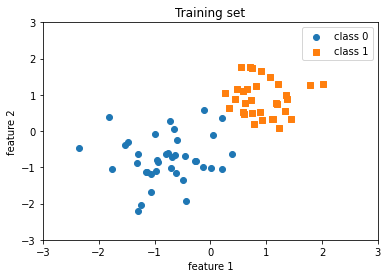

In [5]:
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')
plt.title('Training set')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend()
plt.show()

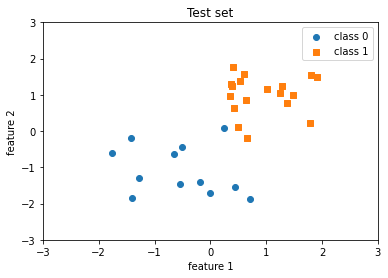

In [6]:
plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')
plt.title('Test set')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend()
plt.show()

## Defining the Perceptron model

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())


class Perceptron():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, 
                                   dtype=torch.float32, device=device)
        self.bias = torch.zeros(1, dtype=torch.float32, device=device)
        
        # placeholder vectors so they don't
        # need to be recreated each time
        self.ones = torch.ones(1).to('cuda')  #Ahmed: added to.('cuda') to send tensors used in prediction to GPU device
        self.zeros = torch.zeros(1).to('cuda')

    def forward(self, x):
        linear = torch.mm(x, self.weights) + self.bias
        print(linear)
        predictions = torch.where(linear > 0., self.ones, self.zeros)
        return predictions
        
    def backward(self, x, y):  
        predictions = self.forward(x)
        errors = y - predictions
        return errors
        
    def train(self, x, y, epochs):
        for e in range(epochs):
            
            for i in range(y.shape[0]):
                # use view because backward expects a matrix (i.e., 2D tensor)
                errors = self.backward(x[i].reshape(1, self.num_features), y[i]).reshape(-1)
                self.weights += (errors * x[i]).reshape(self.num_features, 1)
                self.bias += errors
                
    def evaluate(self, x, y):
        predictions = self.forward(x).reshape(-1)
        accuracy = torch.sum(predictions == y).float() / y.shape[0]
        return accuracy

False


## Training the Perceptron

In [10]:
ppn = Perceptron(num_features=2)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

ppn.train(X_train_tensor, y_train_tensor, epochs=5)

print('Model parameters:')
print('  Weights: %s' % ppn.weights)
print('  Bias: %s' % ppn.bias)

tensor([[0.]], device='cuda:0')
tensor([[-1.2895]], device='cuda:0')
tensor([[4.5939]], device='cuda:0')
tensor([[2.4771]], device='cuda:0')
tensor([[-0.8852]], device='cuda:0')
tensor([[0.3610]], device='cuda:0')
tensor([[-0.7849]], device='cuda:0')
tensor([[-5.7790]], device='cuda:0')
tensor([[3.0213]], device='cuda:0')
tensor([[4.1972]], device='cuda:0')
tensor([[-3.5266]], device='cuda:0')
tensor([[-3.6233]], device='cuda:0')
tensor([[4.1094]], device='cuda:0')
tensor([[-1.9924]], device='cuda:0')
tensor([[-5.4061]], device='cuda:0')
tensor([[-3.1780]], device='cuda:0')
tensor([[2.2034]], device='cuda:0')
tensor([[2.2354]], device='cuda:0')
tensor([[-3.5437]], device='cuda:0')
tensor([[-0.2993]], device='cuda:0')
tensor([[2.8168]], device='cuda:0')
tensor([[1.6426]], device='cuda:0')
tensor([[4.2631]], device='cuda:0')
tensor([[-4.2201]], device='cuda:0')
tensor([[1.2969]], device='cuda:0')
tensor([[-2.9745]], device='cuda:0')
tensor([[4.2390]], device='cuda:0')
tensor([[-2.1447]],

## Evaluating the model

In [11]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

test_acc = ppn.evaluate(X_test_tensor, y_test_tensor)
print('Test set accuracy: %.2f%%' % (test_acc*100))

tensor([[-5.2655],
        [ 2.2333],
        [-3.6607],
        [ 1.2299],
        [ 1.5660],
        [-0.5960],
        [ 1.8989],
        [-2.2295],
        [ 0.9763],
        [-2.6171],
        [ 1.1701],
        [ 1.8495],
        [ 2.3101],
        [ 3.3939],
        [ 1.9910],
        [-2.5183],
        [ 0.7720],
        [ 3.4429],
        [-0.2152],
        [-0.4414],
        [-3.1148],
        [-4.0487],
        [ 1.9062],
        [ 0.3999],
        [-3.3301],
        [-3.0697],
        [-2.6881],
        [-4.3688],
        [ 1.5331],
        [ 1.7889]], device='cuda:0')
Test set accuracy: 93.33%


C:\PythonEnvs\venv\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
C:\PythonEnvs\venv\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


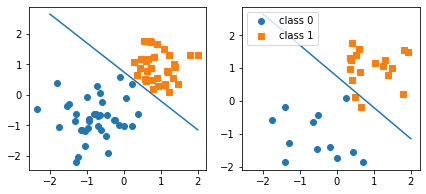

In [12]:
##########################
### 2D Decision Boundary
##########################

w, b = ppn.weights.cpu(), ppn.bias.cpu()  #Ahmed: used .cpu() to send tensors from device to CPU

x0_min = -2
x1_min = ( (-(w[0] * x0_min) - b[0]) 
          / w[1] )

x0_max = 2
x1_max = ( (-(w[0] * x0_max) - b[0]) 
          / w[1] )


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x0_min, x0_max], [x1_min, x1_max])
ax[1].plot([x0_min, x0_max], [x1_min, x1_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()